# To download tweets using twitter APi

'import tweepy\nimport csv #Import csv\nauth = tweepy.auth.OAuthHandler(\'xxxxxxxxx\', \'xxxxxxxxxxxx\')\nauth.set_access_token(\'xxxxxxxxxx\', \'xxxxxxxxxxxx\')\n\napi = tweepy.API(auth,wait_on_rate_limit=True)\n\n# Open/create a file to append data to\ncsvFile = open(\'dataset.csv\', \'a\',encoding="utf-8",newline=\'\')\n\n#Use csv writer\ncsvWriter = csv.writer(csvFile)\n\nfor tweet in tweepy.Cursor(api.search,count=100000,\n                           q = "Covid-19",re.sub(\'[^a-zA-Z]\', \'\',clean )\n                           tweet_mode=\'extended\',\n                           lang = "en").items():\n\n    # Write a row to the CSV file. I use encode UTF-8\n    csvWriter.writerow([tweet.full_text,tweet.user.screen_name,tweet.user.location])\n    print(tweet.full_text,tweet.user.screen_name,tweet.user.location)\ncsvFile.close()'

# Importing dataset and Analysis

In [2]:
import pandas as pd
file_name='dataset (1).csv'
data = pd.read_csv(file_name, sep = ',',names = ['text','username','location'])
data.shape

(131563, 3)

In [3]:
data.head()

,text,username,location
0,RT @tsum_africa: In response to the current #C...,PaulABarter,Singapore
1,RT @FemAdesina: No presidential broadcast on C...,Abdulazizmento2,port Harcourt
2,Covid-19 Outbreak in Nigeria Is Just One of Af...,Ricardo_Gardel,"Tinton Falls, NJ"
3,RT @ChangeOrg_India: Walking miles without foo...,ahumanenough,NaN
4,RT @GhulamABilour: I have been tested positive...,tormakhay_s,"Sexi, Peru"


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131563 entries, 0 to 131562
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   text      131563 non-null  object
 1   username  131563 non-null  object
 2   location  92721 non-null   object
dtypes: object(3)
memory usage: 3.0+ MB


In [5]:
data=data[(data['location'].notnull())]                      #dropping empty row
data = data.sample(frac=1).reset_index(drop=True)           #resetting index
data['len']=data["text"].str.len()                          #removing clipped tweets
df1= data[(data['len'] <=137)]
df2=data[(data['len'] >=150)]
data=pd.concat([df1,df2])                              
data = data.sample(frac=1).reset_index(drop=True)       #resetting index      

In [6]:
data.shape

(35482, 4)

In [7]:
data.head()

,text,username,location,len
0,New York admits knowingly undercounting COVID-...,motorrader1,Lost in the Socialist Void,131
1,FDR wouldn’t have fought the Axis the way Trum...,DudekLinda,"Texas, USA",114
2,@Natabaalo @tufre80 I think you have Covid 19 ...,ianbuyinza,"Stockholm, Sweden",286
3,COVID-19 crisis has set insurers on a drive to...,ElizaaDavies,new york,224
4,Is COVID-19 Killing Democracy? https://t.co/zR...,aya_mr_aya,Republic of Serbia,54


# Cleaning data set by removing RT ,Links and @username

In [8]:
import numpy as np
import re
def remove_pattern(input_txt, pattern):                                           #function to remove pattern 
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)        
    return input_txt
def clean_tweets(lst):
    lst = np.vectorize(remove_pattern)(lst, "\r")                                  
    lst = np.vectorize(remove_pattern)(lst, "\n")
    lst = np.vectorize(remove_pattern)(lst, "RT @[\w]*:")                         # removing RT @x from tweets:
    lst = np.vectorize(remove_pattern)(lst, "@[\w]*")                             # removing  @xxx from tweets 
    lst = np.vectorize(remove_pattern)(lst, "https?://[A-Za-z0-9./]*")            # reremoving URL links http://xxx
    return lst

In [9]:
data['clean']= clean_tweets(data['text'])   #Cleaned Tweets are kept in separate coloumn

In [10]:
data.head()

,text,username,location,len,clean
0,New York admits knowingly undercounting COVID-...,motorrader1,Lost in the Socialist Void,131,New York admits knowingly undercounting COVID-...
1,FDR wouldn’t have fought the Axis the way Trum...,DudekLinda,"Texas, USA",114,FDR wouldn’t have fought the Axis the way Trum...
2,@Natabaalo @tufre80 I think you have Covid 19 ...,ianbuyinza,"Stockholm, Sweden",286,I think you have Covid 19 under control. How...
3,COVID-19 crisis has set insurers on a drive to...,ElizaaDavies,new york,224,COVID-19 crisis has set insurers on a drive to...
4,Is COVID-19 Killing Democracy? https://t.co/zR...,aya_mr_aya,Republic of Serbia,54,Is COVID-19 Killing Democracy?


# Function to label tweets based on their sentiment.

In [11]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer           #vaderSentiment is used to tag tweets as positive, negative or neutral
analyser = SentimentIntensityAnalyzer()
def sentiment_analyzer_scores(text):
    score = analyser.polarity_scores(text)
    if score['compound'] >= 0.05 :
        return 2
    elif (score['compound'] > -0.05) and (score['compound'] < 0.05) : 
        return 1 
    else :
        return 0

In [12]:
sentiments_using_vader = data.clean.apply(lambda text: sentiment_analyzer_scores(text))     #Each tweet goes throug vader function and gets labeled.
pd.DataFrame(sentiments_using_vader.value_counts())

,clean
2,15621
0,10361
1,9500


In [13]:
data['sentiment'] = sentiments_using_vader
data.head()

,text,username,location,len,clean,sentiment
0,New York admits knowingly undercounting COVID-...,motorrader1,Lost in the Socialist Void,131,New York admits knowingly undercounting COVID-...,2
1,FDR wouldn’t have fought the Axis the way Trum...,DudekLinda,"Texas, USA",114,FDR wouldn’t have fought the Axis the way Trum...,0
2,@Natabaalo @tufre80 I think you have Covid 19 ...,ianbuyinza,"Stockholm, Sweden",286,I think you have Covid 19 under control. How...,0
3,COVID-19 crisis has set insurers on a drive to...,ElizaaDavies,new york,224,COVID-19 crisis has set insurers on a drive to...,0
4,Is COVID-19 Killing Democracy? https://t.co/zR...,aya_mr_aya,Republic of Serbia,54,Is COVID-19 Killing Democracy?,0


In [14]:
data.describe()

,len,sentiment
count,35482.000000,35482.000000
mean,162.006961,1.148244
std,77.083169,0.842794
min,8.000000,0.000000
25%,98.000000,0.000000
50%,129.000000,1.000000
75%,233.000000,2.000000
max,832.000000,2.000000


# Removing special characters, numbers, punctuations (except for #)

In [15]:
# remove special characters, numbers, punctuations (except for #)
data['clean'] = data['clean'].str.replace("[^a-zA-Z# ]", "")

# Removing stopwords ,converting into lower case and applying lematization.

In [16]:
from nltk.stem import WordNetLemmatizer
wl = WordNetLemmatizer()
from nltk.corpus import stopwords
cleaned_tweets = []
for index, row in data.iterrows():            #This loop goes through every tweets and removes stopwords covnverts into lower case and applyes lematization
    words_without_stopwords = [wl.lemmatize(word.lower()) for word in row.clean.split() if not word in set(stopwords.words('english')) and '#' not in word.lower()]
    cleaned_tweets.append(' '.join(words_without_stopwords))
data['Fully_cleaned_tweets'] = cleaned_tweets
data.head(10)

,text,username,location,len,clean,sentiment,Fully_cleaned_tweets
0,New York admits knowingly undercounting COVID-...,motorrader1,Lost in the Socialist Void,131,New York admits knowingly undercounting COVID ...,2,new york admits knowingly undercounting covid ...
1,FDR wouldn’t have fought the Axis the way Trum...,DudekLinda,"Texas, USA",114,FDR wouldnt have fought the Axis the way Trump...,0,fdr wouldnt fought axis way trump fighting cov...
2,@Natabaalo @tufre80 I think you have Covid 19 ...,ianbuyinza,"Stockholm, Sweden",286,I think you have Covid under control Howeve...,0,i think covid control however youre ignoring p...
3,COVID-19 crisis has set insurers on a drive to...,ElizaaDavies,new york,224,COVID crisis has set insurers on a drive towar...,0,covid crisis set insurer drive towards wider a...
4,Is COVID-19 Killing Democracy? https://t.co/zR...,aya_mr_aya,Republic of Serbia,54,Is COVID Killing Democracy,0,is covid killing democracy
5,"Covid-19: Brazil Joins Worst Hit Countries, Ci...",ChapterWale,Ghana,98,Covid Brazil Joins Worst Hit Countries City Ho...,0,covid brazil join worst hit country city hospi...
6,In a shocking development the President of Mad...,Max_Positivus,Somewhere in Galaxy far away,264,In a shocking development the President of Mad...,0,in shocking development president madagascar m...
7,RT @horusblog: Italy to ease lockdown weeks af...,abujastreets,"Abuja, Nigeria",102,Italy to ease lockdown weeks after highest Co...,0,italy ease lockdown week highest covid death toll
8,@iamLucretiaMott Perhaps I'm being a little pr...,BryanJLevek,The Known Universe,189,Perhaps Im being a little presumptuous but al...,0,perhaps im little presumptuous state gleefully...
9,🇺🇸This map shows where U.S residents are at in...,HiChi23,"Laren, Noord-Holland",227,This map shows where US residents are at incre...,0,this map show u resident increased risk severe...


# Bargraph of Sentiment

[Text(0, 0.5, '#Tweets'),
 Text(0.5, 0, 'Negative              Neutral               Positive'),
 Text(0.5, 1.0, 'Tweets of USA-corona')]

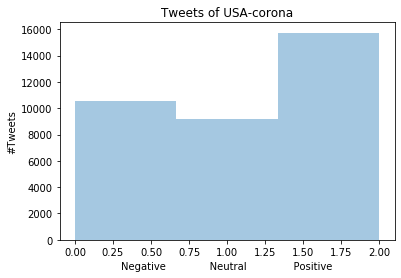

In [17]:
import seaborn as sns
sents =[]
for tw in data.Fully_cleaned_tweets:
    st = sentiment_analyzer_scores(tw)
    sents.append(st)
ax = sns.distplot(sents,kde=False,bins=3)
ax.set(xlabel='Negative              Neutral               Positive',ylabel='#Tweets',title="Tweets of USA-corona")


# Emotion of the tweets

In [18]:
from collections import Counter

def con(sentence):
    emotion_list = []
    sentence = sentence.split(' ')
    with open('emotions.txt','r') as file:
        for line in file:
            clear_line = line.replace("\n", '').replace(",",'').replace("'",'').strip()
            word, emotion = clear_line.split(':')

            if word in sentence:
                emotion_list.append(emotion)
        w = Counter(emotion_list)
        return w
    

In [19]:
data['emotion'] = data['Fully_cleaned_tweets'].apply(lambda x: con(x) )

In [20]:
data.head(10)

,text,username,location,len,clean,sentiment,Fully_cleaned_tweets,emotion
0,New York admits knowingly undercounting COVID-...,motorrader1,Lost in the Socialist Void,131,New York admits knowingly undercounting COVID ...,2,new york admits knowingly undercounting covid ...,{}
1,FDR wouldn’t have fought the Axis the way Trum...,DudekLinda,"Texas, USA",114,FDR wouldnt have fought the Axis the way Trump...,0,fdr wouldnt fought axis way trump fighting cov...,{}
2,@Natabaalo @tufre80 I think you have Covid 19 ...,ianbuyinza,"Stockholm, Sweden",286,I think you have Covid under control Howeve...,0,i think covid control however youre ignoring p...,{}
3,COVID-19 crisis has set insurers on a drive to...,ElizaaDavies,new york,224,COVID crisis has set insurers on a drive towar...,0,covid crisis set insurer drive towards wider a...,{}
4,Is COVID-19 Killing Democracy? https://t.co/zR...,aya_mr_aya,Republic of Serbia,54,Is COVID Killing Democracy,0,is covid killing democracy,{}
5,"Covid-19: Brazil Joins Worst Hit Countries, Ci...",ChapterWale,Ghana,98,Covid Brazil Joins Worst Hit Countries City Ho...,0,covid brazil join worst hit country city hospi...,{}
6,In a shocking development the President of Mad...,Max_Positivus,Somewhere in Galaxy far away,264,In a shocking development the President of Mad...,0,in shocking development president madagascar m...,{}
7,RT @horusblog: Italy to ease lockdown weeks af...,abujastreets,"Abuja, Nigeria",102,Italy to ease lockdown weeks after highest Co...,0,italy ease lockdown week highest covid death toll,{}
8,@iamLucretiaMott Perhaps I'm being a little pr...,BryanJLevek,The Known Universe,189,Perhaps Im being a little presumptuous but al...,0,perhaps im little presumptuous state gleefully...,{}
9,🇺🇸This map shows where U.S residents are at in...,HiChi23,"Laren, Noord-Holland",227,This map shows where US residents are at incre...,0,this map show u resident increased risk severe...,{}


In [21]:
emo=con(data['Fully_cleaned_tweets'].sum())

In [22]:
data['text'][8]

"@iamLucretiaMott Perhaps I'm being a little presumptuous, but all these states that are gleefully reopening will see more cases of Covid-19 and more death. \n\nI don't get it. Why tempt fate?"

# Plotting emotion bar graph

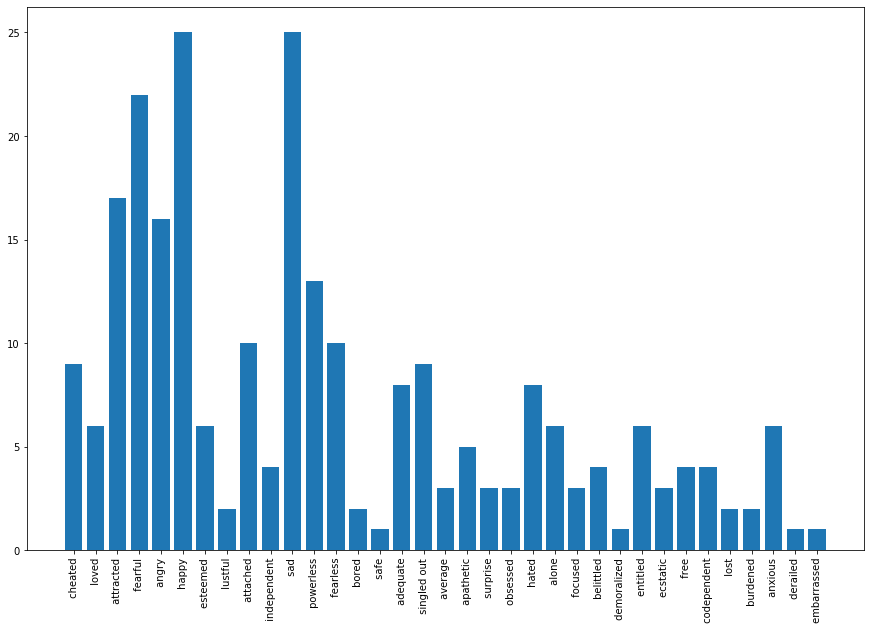

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize = (15,10))
plt.bar(emo.keys(),emo.values())
plt.xticks(rotation = 90)
plt.show()

# Wordcloud

In [24]:
from PIL import Image
from wordcloud import WordCloud,ImageColorGenerator
import urllib
import requests
import matplotlib.pyplot as plt
def generate_wordcloud(all_words):
    Mask = np.array(Image.open(requests.get('http://clipart-library.com/image_gallery2/Twitter-PNG-Image.png', stream=True).raw))
    image_colors = ImageColorGenerator(Mask)
    wc = WordCloud(background_color='black', height=750, width=2000,mask=Mask).generate(all_words)
    plt.figure(figsize=(10,20))
    plt.imshow(wc.recolor(color_func=image_colors),interpolation="hamming")
    plt.axis('off')
    plt.show()

# Wordcloud for Positive Sentiment

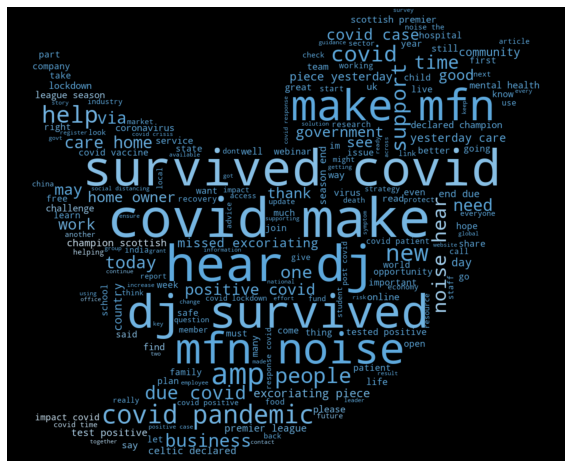

In [25]:
all_words = ' '.join([text for text in data['Fully_cleaned_tweets'][data.sentiment == 2]])
generate_wordcloud(all_words)

# Wordcloud for Neutral Sentiment

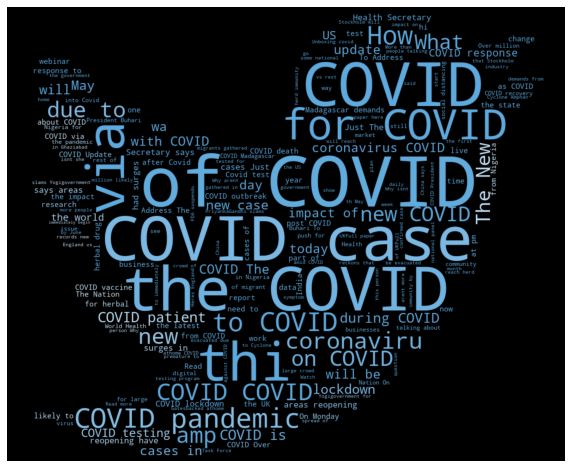

In [26]:
all_words = ' '.join([text for text in data['clean'][data.sentiment == 1]])
generate_wordcloud(all_words)

# Wordcloud for Negative Sentiment

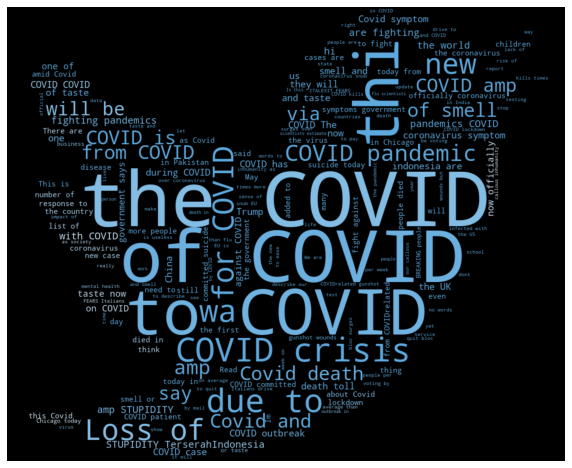

In [27]:
all_words = ' '.join([text for text in data['clean'][data.sentiment == 0]])
generate_wordcloud(all_words)

# Creating Hastag FreqDist

In [28]:
import nltk
                                                  #function to collect hashtags
def hashtag_extract(text_list):
    hashtags = []
    # Loop over the words in the tweet
    for text in text_list:
        ht = re.findall(r"#(\w+)", text)
        hashtags.append(ht)

    return hashtags

def generate_hashtag_freqdist(hashtags):
    a = nltk.FreqDist(hashtags)
    d = pd.DataFrame({'Hashtag': list(a.keys()),
                      'Count': list(a.values())})
    # selecting top 15 most frequent hashtags     
    d = d.nlargest(columns="Count", n = 25)
    plt.figure(figsize=(16,7))
    ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
    plt.xticks(rotation=80)
    ax.set(ylabel = 'Count')
    plt.show()

In [29]:
hashtags = hashtag_extract(data['clean'])
hashtags = sum(hashtags, [])

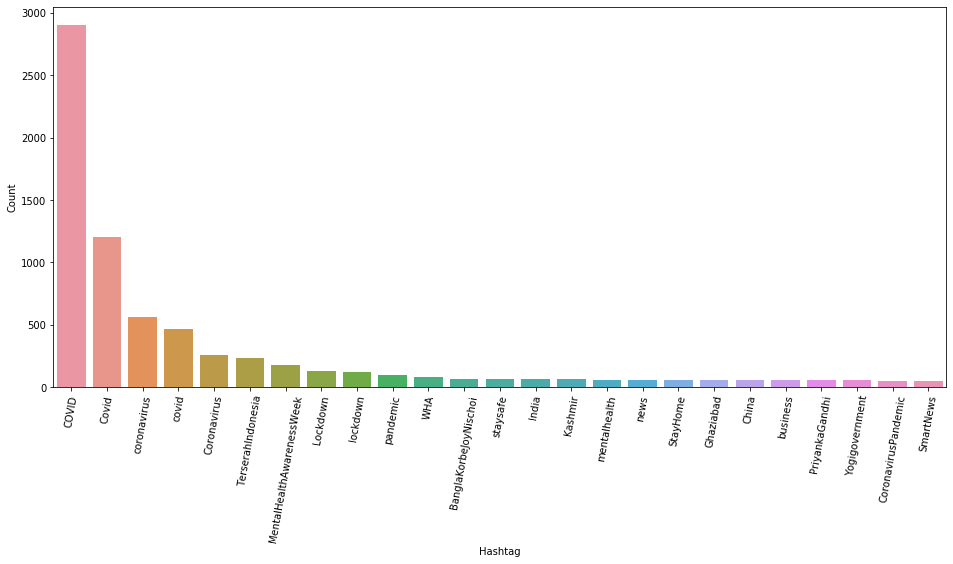

In [30]:
generate_hashtag_freqdist(hashtags)

# Tweets location bargraph

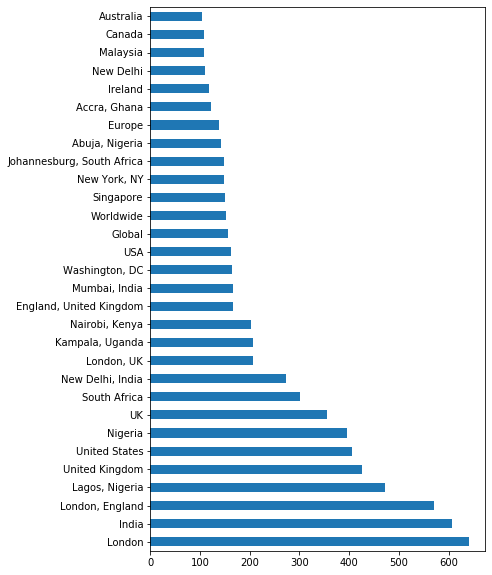

In [31]:
data['location'].value_counts().head(30).plot(kind='barh', figsize=(6,10))

# Extracting X and y from dataset

In [32]:
x = data.iloc[:,-2].values
y = data.iloc[:,-3].values

# Creating tfid vectorizer model

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_word_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, stop_words='english')
x = tfidf_word_vectorizer.fit_transform(x)

# Creating training and test data from the featureset and output label.

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

#  Create and training a Machine Learning model.

In [35]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

# Validate the model created.

In [36]:
predictions = classifier.predict(X_test.toarray())

# Predicting sentiment of manual input

In [37]:
file_name='TestTweet.csv'
test=pd.read_csv(file_name)  

In [38]:
test['clean']=clean_tweets(test['text']) 
test['clean']=test['clean'].str.replace("[^a-zA-Z ]", " ")

In [39]:
for i,tweet in enumerate(test['clean']):
    op=classifier.predict(tfidf_word_vectorizer.transform([tweet]).toarray())
    if op == [0]:
        print(i,")"," ' ",test.text[i]," ' ",'\n','=','NEGATIVE','\n')
    if op == [1]:
        print(i,")"," ' ",test.text[i]," ' ",'\n','=','NEUTRAL','\n')
    if op == [2]:
        print(i,")"," ' ",test.text[i]," ' ",'\n','=','POSITIVE','\n')

0 )  '  RT @djnicholl: Show us proof that Johnson is following science, MPs urge 

https://t.co/aN9ofVaQBV  '  
 = NEUTRAL 

1 )  '  Why people think 5G responsible for coronavirus https://t.co/jloVJuO0G0 via @YouTube  '  
 = NEUTRAL 

2 )  '  Yesterday I was walking along a pier of the #Amsterdam Oude Houthaven when an angry houseboat resident invited me leave as "they don't like walkers due to the #coronavirus" WTF...  '  
 = POSITIVE 

3 )  '  RT @WyeLea: The coronavirus crisis must not be allowed to delay Brexit https://t.co/4n6mip2MVg  '  
 = NEGATIVE 

4 )  '  #N4P #C4XD #IQAI 
Coronavirus: Moderna’s US vaccine first trials show immune response https://t.co/2vy25EMqEY  '  
 = POSITIVE 

5 )  '  @HeshmatAlavi China knew what they were doing as soon as President Trump signed those papers. China will fulfill their deal as long as no pandemic happens. TWO days later &amp; here is Coronavirus knocking at our doors! Sue them, I say.  '  
 = NEGATIVE 

6 )  '  RT @jonworth: Even by Brex

47 )  '  The latest on the coronavirus outbreak with Bobby @bobbyisawake &amp; Stacy @Livviesmomma -
✅DeWine: Bar owners could lose their liquor licenses if they don’t control their customers
✅Experimental vaccine shows encouraging results
✅Trump taking hydroxychloroquine https://t.co/rAhIv5Wmki  '  
 = NEGATIVE 

48 )  '  RT @RealJamesWoods: And if not, CNN will do everything it can to get us there...  https://t.co/tXG0u7XFKO  '  
 = NEUTRAL 

49 )  '  @WyeLea Agreed 100% Let's face it, we are already in a situation of a severe downturn due to the Coronavirus. The remainer argument about supply chains won't matter as we are already badly affected (for now). So we may as leave as things cannot get any worse, only much better.  '  
 = POSITIVE 

50 )  '  RT @EaterSouls: 72 people test positive for coronavirus after mass lockdown protest in Wisconsin https://t.co/CDzqAt6aAw  '  
 = POSITIVE 

51 )  '  Joining @SeneddCWLC is Nick Capaldi, Chief Executive @Arts_Wales_. Giving evidence on b

https://t.co/2tX3WUZxSo  '  
 = NEGATIVE 

99 )  '  Cannabis extracts may help to prevent coronavirus, study suggests https://t.co/8kCRJXEIez #CannabisNews #Cannabis  '  
 = POSITIVE 

100 )  '  During these uncertain times, many of us will be worried about how we manage our rent 🏠 

We are here to help you
Talk to us 💬

The following organisations have guidance on how Coronavirus may affect income &amp; benefits ⬇️

🟡 @DWP 
🟠 @CitizensAdvice 
🟢 @YourMoneyAdvice https://t.co/VRhGlbZT4n  '  
 = POSITIVE 

101 )  '  The Government has issued an update on the symptoms of coronavirus - see below. https://t.co/TkkWJgwP1q  '  
 = NEUTRAL 

102 )  '  RT @Partisangirl: Just realise that outside of the US #Hydroxycloroquine is not a controversial drug. https://t.co/mYg3Y3Hw9E  '  
 = NEUTRAL 

103 )  '  RT @Peston: Why didn't the government protect us earlier from coronavirus? https://t.co/RslSSTYnvp  '  
 = NEUTRAL 

104 )  '  @lisamurkowski Imagine the difference if Trump Republicans spent as

152 )  '  #Oregon coronavirus restrictions kept in place, for now - May 19 @ 4:15 AM ET https://t.co/Pv8sry0tR1  '  
 = NEUTRAL 

153 )  '  Saturday Sunshine Drenched Beltzville Park
Friday was the first day coronavirus lockdown orders were lifted at Beltzville State Park in Carbon County, 54 miles north of Sanatoga. By Saturday, plenty of people were enjoying sunny time there.
https://t.co/fUDunSAyCl https://t.co/DjQoTFguiJ  '  
 = POSITIVE 

154 )  '  RT @wellbeingvenues: How has lockdown changed Yoga?

https://t.co/R0rgINZmYF

#yoga #coronavirus #onlineyoga  '  
 = NEUTRAL 

155 )  '  RT @Isabel21294528: @CGTNOfficial #Hubei measures the culture and traavel industry #coronavirus 🇨🇳  '  
 = NEUTRAL 

156 )  '  @Ericyip77316500 Past vaccines took many more years to develop. 
According to scientists, SARS-CoV-2, like other coronavirus, doesn't mutate as much. But, doctors found it dangerous and intractable. It can attack anywhere in the body w. devastating consequences.  '  
 = NEGATIV

204 )  '  RT @Pun_Starr: I think BJP leaders should most beware of Zee News journalists. Coronavirus can be transferred through boot licking.  '  
 = NEGATIVE 

205 )  '  Second https://t.co/R7Yzduz9J5. Corrections Officer Tests Positive For Coronavirus https://t.co/0JEK8Vksvc  '  
 = POSITIVE 

206 )  '  The Trump Administration Is Rushing Deportations of #Migrants Children During #Coronavirus #COVID19  https://t.co/CABU0Ahlmz  '  
 = NEUTRAL 

207 )  '  ‘The Morrison Govt’s refusal 2 extend JobKeeper 2 unis is having real consequences - regional campuses closing, hundreds of jobs lost. They could fix it with the stroke of a pen’

Staff accept voluntary redundancies as CQU struggles with $116m loss https://t.co/UbgnCuiVky  '  
 = NEGATIVE 

208 )  '  I don't think that 'let them pick spuds' is a particualatly good luck. The nasty party goes back to type here as minister says there are plenty of jobs. https://t.co/X8FOnEpKg1  '  
 = POSITIVE 

209 )  '  "The police, not the coronavirus

In [40]:
tweet="@briantylercohen Hey #Insane @realDonaldTrump ! Are you crazy? ANY of them don't need to die at all."
clean=clean_tweets(tweet)
clean=str(clean)
clean=re.sub('[^a-zA-Z]', ' ',clean )
clean=[clean]
op=classifier.predict(tfidf_word_vectorizer.transform(clean).toarray())
if op == [0]:
    print(tweet,'\n','=','NEGATIVE','\n')
if op == [1]:
    print(tweet,'\n','=','NEUTRAL','\n')
if op == [2]:
    print(tweet,'\n','=','POSITIVE','\n')

@briantylercohen Hey #Insane @realDonaldTrump ! Are you crazy? ANY of them don't need to die at all. 
 = NEGATIVE 



# Evaluate the model

In [41]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print('Accuracy score : ',accuracy_score(y_test, predictions)*100,'\n')

Accuracy score :  84.0495984218684 



In [42]:
print(confusion_matrix(y_test,predictions),'\n')

[[1528  236  266]
 [  68 1674  149]
 [ 148  265 2763]] 



In [43]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.88      0.75      0.81      2030
           1       0.77      0.89      0.82      1891
           2       0.87      0.87      0.87      3176

    accuracy                           0.84      7097
   macro avg       0.84      0.84      0.83      7097
weighted avg       0.84      0.84      0.84      7097

